![](../images/rivacon_frontmark_combined_header.png)

In [1]:
from math import exp
from pandas import DataFrame
from datetime import datetime
from dateutil.relativedelta import relativedelta
from pyriva.enums import DBUdl
from pyriva.enums import DayCounter
from pyriva.enums import SecuritizationLevel
from pyriva.enums import InterpolationType
from pyriva.enums import ExtrapolationType
from pyriva.enums import InflationInterpolation
from pyriva.instruments import ZeroBondSpecification
from pyriva.instruments import FixedRateBondSpecification
from pyriva.instruments import FloatingRateNoteSpecification
from pyriva.instruments import GeneralBondSpecification
import pyriva

In [2]:
if True:
    #
    import pyvacon
    import pyvacon.models.tools as model_tools
    import pyvacon.models.plot as model_plot
    import pyvacon.marketdata.testdata as mkt_testdata
    import pyvacon.marketdata.plot as mkt_plot

    import matplotlib.pyplot as plt
    %matplotlib inline

    from plotly.offline import init_notebook_mode, iplot
    from plotly.graph_objs import *

    init_notebook_mode(connected=True)

In [3]:
pyriva.set_log_level('DEBUG')

# Bonds

## Setup Specifications

### Reference Date
The reference date defines any date a pricing is performed for. As pre-condition for a sucessful evaluation of a financial instrument all the relevant information, in particular the relevant market data, must be provided for this date. The first time pricing is relevant is the issue date. Therefore is often coincides with the reference date in this notebook.

In [4]:
ref_date = datetime(2010, 1, 23)

### General Bond Specification
<code>pyriva</code> supports the specification of a wide class of bonds including
- **Zero Bonds**: bonds without any coupon payment.
- **Fixed Rate Bonds**: bonds with fixed coupons, i.e. the amount of the coupon payment is known when the bond is issued. 
- **Floating Rate Notes**: bonds with coupon payments that depend on a reference index and their amount, thus, depends on future, i.e. at bond issuance unknown, values of this reference index. It is possible to add coupon-specific spreads to the floating rate coupon payments. <br>
Note: The specification of floating rate notes (FRNs) allows for different curves for discounting and fixing the cashflows. Decoupling the discount curve from the fixing curve is especially important for the acknowledgement of risk adjustments by adding (potentially time dependent) credit spreads to the discount curve in the discounted cashflow valuation model. In general, the FRN specification is <u>not</u> intended to be used for bonds with different dynamics in the discount and fixing curve, e.g. for bonds with 10y pension index used for fixing. The valuation of these bonds would require more sophisticated model or - at least - to include a convexity adjustment.
- **Fixed-to-Float Bonds**: bonds with both, fixed coupons and coupons that depend on a reference index.
- **Callable/Putable Bonds**: <font color='red'>... [SW] sobald die Schnittstelle zum bereits vorhandenen entsprechenden C++-Code angespasst ist ...</font>

### Zero Bond
A zero-coupon bond is a debt instrument where the face value is repaid at expiry. It does not have any so-called coupons, i.e. it does not make any periodic interest payments. When the bond reaches maturity, its investor receives its par (or face) value. Examples of zero-coupon bonds include U.S. Treasury bills, U.S. savings bonds, long-term zero-coupon bonds.

(Source: Wikipedia)

In [5]:
#help(ZeroBondSpecification) # For help, please uncomment this line.

#### Minimal Specification
The <code>ZeroBondSpecification</code> expects the following parameters:
- **Object Id** <br>
  The object Id is a (preferably unique) identifying name (in string format) of the specified object, e.g. the ISIN. It is for identifiying purposes only, i.e. the bond valuation is not affected by the value for object Id.


- **Currency** <br>
  Though the currency is not necessarily used in the pricer, it has to be available in the frontmark market data manager. Any input of a ISO currency code (ISO 4217) as three-letter-string shall be fine, e.g. <code>'EUR'</code>. The information is evaluated only for identifiying an appropriate risk adjusted discount curve unless it is provided manually.


- **Issue Date** <br>
  Instrument's issue date in datetime format, e.g. <code>datetime(2017, 02, 20)</code>.


- **Expiry Date** <br>
  Instrument's expiry date in datetime format, e.g. <code>datetime(2022, 02, 20)</code>. The expiry date determines the payment date of the notional. Obviously the expiry date must be after the issue date. The bond pricer does not account for the issue date as all future payments relevant for the bond's price are independent from the issue date. (The issue date is, however, used to double-check potential mistakes in defining coupon scheduls by validating that they are between issue and expiry date.)

In [6]:
issue_date = ref_date
maturity = 5
expiry_date = issue_date + relativedelta(years = maturity)
zero_bond = ZeroBondSpecification(obj_id = 'Test_Zero_Bond', curr = 'EUR', issue_date = issue_date, 
                                  expiry = expiry_date)
# zero_bond.get_dictionary()

#### Full Specification
Addionally, you can provide <code>ZeroBondSpecification</code> with the following information to deviate from default values or to allow more sophisticated pricing algorithms:
- **Notional** <br>
  Bond's face value as float number, e.g. <code>100.0</code>. The face value is set to 100.0 if no notional is provided. Otherwise the notional must be positive.


- **Issuer** <br>
  The bond issuer is given in string format. It could be used to identify an appropriate risk adjusted discount curve in the frontmark market data manager. In general, this market data manager provides mapping rules for the combination of 
<ul>
    <li>the sector associated with the issuer,</li>
    <li>the rating associated with the issuer,</li>
    <li>the securitization level of the bond, and</li>
    <li>the currency of the bond.</li>
</ul>
However, there the market data manager also allows for more specific mapping, e.g. for issuer specific spreads in order to consider idiosyncratic behaviour rather than sector and rating specific one, only. <br>
If the discount curve is provided manually the issuer information is irrelevant for pricing. Thus, it is possible to provide a dummy issuer, e.g. by <code>'dummy_issuer'</code> (= Default Value). On the other hand, <code>pyriva.enums</code>has to provide a mapping of the chosen string to the issuer identifyer in the frontmark market data manager before you can make use of it.


- **Securitisation Level** <br>
  Currently the following levels are supported:
    * <code>pyriva.enums.SecuritizationLevel.NONE</code> (= Default Value)
    * <code>pyriva.enums.SecuritizationLevel.COLLATERALIZED</code>
    * <code>pyriva.enums.SecuritizationLevel.SENIOR_SECURED</code>
    * <code>pyriva.enums.SecuritizationLevel.SENIOR_UNSECURED</code>
    * <code>pyriva.enums.SecuritizationLevel.SUBORDINATED</code>
    * <code>pyriva.enums.SecuritizationLevel.MEZZANINE</code>
    * <code>pyriva.enums.SecuritizationLevel.EQUITY</code>
</ul>
As mentioned above (see 'Issuer') the securitisation level is used for selecting an appropriate risk adjusted discount curve in the frontmark market data manager if you want to use it. The securitisation level is ignored if the discount curve is provided manually. However, one of the values listed above must be set in order to avoid error messages.

In [7]:
issue_date = ref_date
maturity = 5
expiry_date = issue_date + relativedelta(years = maturity)
# additional (optional) specification parameters
notional = 100.0
issuer = DBUdl.BMW
sec_level = SecuritizationLevel.NONE
zero_bond_extended = ZeroBondSpecification('Test_Zero_Bond', curr = 'EUR', issue_date = ref_date, 
                                           expiry = expiry_date, notional = notional, 
                                           issuer = issuer, sec_level = sec_level)
# zero_bond.get_dictionary()

### Fixed Rate Bond
A fixed rate bond is a debt instrument with a fixed interest rate payments, so-called coupons, defined by predetermined coupon rates (= annualized interest rates) times the bond's notional. The coupon payments are performed at specified dates before bond maturity.
Due to the fixed coupon, the fixed rate bond exhibits a significant amount of interest rate risk, i. e. its market value is susceptible to fluctuations in interest rates. That being said, the fixed-rate bond, although a conservative investment, is highly susceptible to a loss in value due to inflation. The fixed-rate bond’s long maturity schedule and predetermined coupon rate offers an investor a solidified return, while leaving the individual exposed to a rise in the consumer price index and overall decrease in their purchasing power.

The coupon rate attached to the fixed-rate bond is payable at specified dates before the bond reaches maturity; the coupon rate and the fixed-payments are delivered periodically to the investor at a percentage rate of the bond’s face value. Due to a fixed-rate bond’s lengthy maturity date, these payments are typically small and as stated before are not tied into interest rates.

(Source: Wikipedia)

In [8]:
#help(FixedRateBondSpecification) # For help, please uncomment this line.

#### Minimal Specification
Additonal to the <code>ZeroBondSpecification</code> the <code>FixedRateBondSpecification</code> expects the following parameters:
- **Fixed Rate Coupon Payment Dates** <br>
For fixed rate coupons the payment dates must be provided as list of dates in datetime format, e.g. <code>[datetime.datetime(2018, 2, 20, 0, 0), datetime.datetime(2019, 2, 20, 0, 0), datetime.datetime(2020, 2, 20, 0, 0), datetime.datetime(2021, 2, 20, 0, 0)]</code>. The coupon dates must be between the issue and the expiry date!


- **Fixed Coupon Rates** <br>
For fixed rate coupons the size of the coupon payment is given as fraction of the notional. Therefore, the fixed coupon rates must be provided as list of corresponding float numbers. Example: A fixed coupon bond with notional 1,000,000 EUR and a maturity of 5 years has a yearly rate of 6% and pays semiannually, i.e. coupons of 3%. Thus, there are 10 coupon payments of 30,000 EUR and the fixed coupon rates to be provided are <code>[0.03]*10</code>. Of course, the length of the fixed coupon rate list must be identical to the one of the coupon payment date list.

In [9]:
issue_date = ref_date
maturity = 5
expiry_date = issue_date + relativedelta(years=maturity)
# generate coupon dates manually (ignoring holiday calendars and roll conventions)
period = 12
coupon_dates = [issue_date + (n+1)*relativedelta(months=period) for n in range(int(maturity*12/period))]
# define fixed rate coupons
coupon = 0.01
coupons = [coupon]*len(coupon_dates)
fixed_coupon_bond = FixedRateBondSpecification(obj_id = 'Test_Fixed_Rate_Bond', curr = 'EUR',
                                               issue_date = issue_date, expiry = expiry_date,
                                               coupon_dates = coupon_dates, coupons = coupons)
# fixed_coupon_bond.get_dictionary()

#### Full Specification
Addionally, you can provide <code>FixedRateBondSpecification</code> with the more parameters to deviate from default values or to allow more sophisticated pricing algorithms. Besindes the ones mentioned for the full <code>ZeroBondSpecification</code> this is:
- **Day Count Convention** <br>
  The day count convention (dcc) defines the method for determining the number of days between two fixed dates, e.g. coupon payments dates, as fraction of a year. Thus, the dcc is important for calculating the amount transferred on payment dates and the accrued interests for dates between payments as well as for counting days when quantifying periods of time by discounting cashflows for pricing purposes. For details refer to the [schedule generation notebook](../marketdata/daycounter_rollconventions_schedules.ipynb). <br>
Currently the following conventions are supported:
    * <code>pyriva.enums.DayCounter.ACT252</code>
    * <code>pyriva.enums.DayCounter.ACT2360</code>
    * <code>pyriva.enums.DayCounter.ACT365_FIXED</code> (= Default Value)
    * <code>pyriva.enums.DayCounter.ACTACT</code>
    * <code>pyriva.enums.DayCounter.ThirtyE360</code>
    * <code>pyriva.enums.DayCounter.ThirtyU360</code>

In [10]:
issue_date = ref_date
maturity = 5
expiry_date = issue_date + relativedelta(years=maturity)
# generate coupon dates manually (ignoring holiday calendars and roll conventions)
period = 12
coupon_dates = [issue_date + (n+1)*relativedelta(months=period) for n in range(int(maturity*12/period))]
# define fixed rate coupons
coupon = 0.01
coupons = [coupon]*len(coupon_dates)
# additional (optional) specification parameters
notional = 100.0
day_count_convention = DayCounter.ACT365_FIXED
issuer = DBUdl.BMW
sec_level = SecuritizationLevel.NONE
fixed_coupon_bond_extended = FixedRateBondSpecification(obj_id = 'Test_Fixed_Rate_Bond', curr = 'EUR',
                                                        issue_date = issue_date, expiry = expiry_date,
                                                        coupon_dates = coupon_dates, coupons = coupons,
                                                        notional = notional, day_count = day_count_convention,
                                                        issuer = issuer, sec_level = sec_level)
# fixed_coupon_bond_extended.get_dictionary()

### Floating Rate Note
Floating rate note is a type of bond that contains a variable coupon that is equal to a money market reference rate, or a federal funds rate plus a specified spread. Although the spread remains constant, the majority of floating rate notes contains quarterly coupons that pay-out interest every 3 months with variable percentage returns. At the beginning of each coupon period, the rate is calculated by adding the spread with the reference rate. This structure differs from the fixed-bond rate which locks in a coupon rate and delivers it to the holder, e.g. semi-annually over a course of multiple years.

(Souce: Wikipedia)

In [11]:
#help(FloatingRateNoteSpecification) # For help, please uncomment this line.

#### Minimal Specification
Additonal to the <code>ZeroBondSpecification</code> the <code>FloatingRateNoteSpecification</code> expects the following parameters:
- **Floating Rate Coupon Periods** <br>
In contrast to fixed rate coupons for floating rate coupons not only the payment dates but the complete coupon periods, i.e. including accrual start and end date, must be specified. This additional information is needed for the calculation of the period's length, which defined the size of the floating rate coupon. Similar to the fixed coupon dates the coupon periods are specified as list of dates in datetime format, e.g. <code>[datetime.datetime(2017, 2, 20, 0, 0), datetime.datetime(2018, 2, 20, 0, 0), datetime.datetime(2019, 2, 20, 0, 0), datetime.datetime(2020, 2, 20, 0, 0), datetime.datetime(2021, 2, 20, 0, 0)]</code>. All coupon periods must be fully between the issue and the expiry date!


- **Floating Rate Spreads** <br>
Finally the parameter spreads determines the addons to the floating rate coupons as for example premium payments or adjustments to account for the creditworthiness of the bond issuer. Similar to fixed coupons the spreads must be specified as list of float numbers defining the fraction of the notional that has to paid on top of the floating rate coupon defined by the reference index. The length of the list must be one element shorter than the length of the coupon period dates.

In [12]:
issue_date = ref_date
maturity = 5
expiry_date = issue_date + relativedelta(years=maturity)
# generate coupon periods manually (ignoring holiday calendars and roll conventions)
period = 6
coupon_periods = [issue_date + n*relativedelta(months=period) for n in range(int(maturity*12/period+1))]
# define the spreads
spread = 0.01
spreads = [spread]*(len(coupon_periods)-1)
float_coupon_bond = FloatingRateNoteSpecification(obj_id = 'Test_Floating_Rate_Note', curr = 'EUR',
                                                  issue_date = issue_date, expiry = expiry_date,
                                                  coupon_periods = coupon_periods, spreads = spreads)
# float_coupon_bond.get_dictionary()

#### Full Specification
Addionally, you can provide <code>FloatingRateNoteSpecification</code> with the more parameters to deviate from default values or to allow more sophisticated pricing algorithms. Besindes the ones already mentioned above for full specifications this is:
- **Reference Index** <br>
Floating rate coupons refer to an interest rate index, e.g. EURIBOR-3M. This reference index will be used for fixing the coupon rate. The reference index can be defined here as string, e.g. <code>'EURIBOR-3M'</code>. This reference index need not to be defined at the bond specification stage. However, the reference index must be defined for pricing, either by providing a reference index with the name specified as reference index of by overwriting this value in the pricing context. The default value for the reference index is <code>''</code>.

In [13]:
issue_date = ref_date
maturity = 5
expiry_date = issue_date + relativedelta(years=maturity)
# generate coupon periods manually (ignoring holiday calendars and roll conventions)
period = 6
coupon_periods = [issue_date + n*relativedelta(months=period) for n in range(int(maturity*12/period+1))]
# define the spreads
spread = 0.01
spreads = [spread]*(len(coupon_periods)-1)
# additional (optional) specification parameters
ref_index = 'dummy_curve'
notional = 100.0
day_count_convention = DayCounter.ACT365_FIXED
issuer = DBUdl.BMW
sec_level = SecuritizationLevel.NONE
float_coupon_bond_extended = FloatingRateNoteSpecification(obj_id = 'Test_Floating_Rate_Note', curr = 'EUR',
                                                           issue_date = issue_date, expiry = expiry_date,
                                                           coupon_periods = coupon_periods, spreads = spreads,
                                                           reference_index = ref_index, notional = notional,
                                                           day_count = day_count_convention, issuer = issuer,
                                                           sec_level = sec_level)
# float_coupon_bond_extended.get_dictionary()

### Fixed-To-Float Bonds
For bonds with both fixed and floating rate bonds the general bond specification is used. Thus, fixed-to-float bonds starting with fixed rate coupons and changing to floating rate coupons after some maturity are specified by <code>GeneralBondSpecification</code>.

#### Minimal Specification

In [14]:
issue_date = ref_date
maturity = 5
fix_to_float = 2
expiry_date = issue_date + relativedelta(years=maturity)
notional = 100.0
period = 3
# fixed rate part
coupon_dates = [issue_date + (n+1)*relativedelta(months=period)
                for n in range(int(fix_to_float*12/period))]
coupon = 0.02
coupons = [coupon]*(len(coupon_dates))
# floating rate part
coupon_periods = [issue_date + n*relativedelta(months=period)
                  for n in range(int(fix_to_float*12/period), int(maturity*12/period+1))]
spread = 0.01
spreads = [spread]*(len(coupon_periods)-1)
# fixed-to-float specification
fixed_to_float_bond = GeneralBondSpecification(obj_id = 'Test_Fixed_to_Float_Bond', curr = 'EUR',
                                               issue_date = issue_date, expiry = expiry_date,
                                               coupon_dates = coupon_dates, coupons = coupons,
                                               coupon_periods = coupon_periods, spreads = spreads)
# fixed_to_float_bond.get_dictionary()

#### Full Specification

In [15]:
issue_date = ref_date
maturity = 5
fix_to_float = 2
expiry_date = issue_date + relativedelta(years=maturity)
notional = 100.0
period = 3
# fixed rate part
coupon_dates = [issue_date + (n+1)*relativedelta(months=period)
                for n in range(int(fix_to_float*12/period))]
coupon = 0.02
coupons = [coupon]*(len(coupon_dates))
# floating rate part
coupon_periods = [issue_date + n*relativedelta(months=period)
                  for n in range(int(fix_to_float*12/period), int(maturity*12/period+1))]
spread = 0.01
spreads = [spread]*(len(coupon_periods)-1)
# additional (optional) specification parameters
ref_index = 'dummy_curve'
notional = 100.0
day_count_convention = DayCounter.ACT365_FIXED
issuer = DBUdl.BMW
sec_level = SecuritizationLevel.NONE
# fixed-to-float specification
fixed_to_float_bond_extended = GeneralBondSpecification(obj_id = 'Test_Fixed_to_Float_Bond', curr = 'EUR',
                                                        issue_date = issue_date, expiry = expiry_date,
                                                        coupon_dates = coupon_dates, coupons = coupons,
                                                        coupon_periods = coupon_periods, spreads = spreads,
                                                        reference_index = ref_index, notional = notional,
                                                        day_count = day_count_convention, issuer = issuer,
                                                        sec_level = sec_level)
# fixed_to_float_bond_extended.get_dictionary()

## Pricing

### Pricing Models

For plain vanilla bonds there are currently two different models available to calculate the fair price: the simple discounted cashflow method and the Jarrow-(Lando-)Turnbull (JLT) model.

#### Simple discounted cashflows
This method uses a (potentially risk-adjusted) discount curve to discount all expected cashflows. To determine the expected cashflow of a floating coupon, the pricer just computes the corresponding forward rate from a explicitly defined fixing curve (also of type discount curve). Let us assume that the bond has $n+1$ cashflows: $n$ coupon payments $c_i$ with $1\leq i\leq n$ and the payment of the notional at the expiry date. The cashflows $c_i$ occur at times $t_i$. Then, the bond's present value is given by

$$V=\sum_{i=1}^n df_i\cdot c_i + df_n\cdot N$$

where $df_i$ is the discount factor at timepoint $i$.

#### JLT
<font color='orange'>**To Do:** describe the JLT model</font>

### Bond Pricer Configuration

#### General Parameters

As explained in [Overview](../overview.ipynb), we need to setup the respective BasePricingData object which is *BondPricingData* for bonds. This object needs the following data:
- **spec**: A BondSpecification object as defined above. It determines the bond's main characteristics, as for example issue and expiry date, notional, etc.
- **param**: The BondPricingParameter object specifies parameters for the pricing methodology to be applied, e.g. shift parmaeters for the calculation of finite differences as approximations for Greeks. In the bond case it also allows to deviate from the simple discounted cashflow model to alternatively available Jarrow-(Lando-)Turnbull (JLT) model.
- **pricingRequest**: The PricingRequest object configures which figures the pricer computes. Currently, the following results are supported that are relevant for bonds (see below):
    * <code>pyvacon.pricing.PricingRequest.setTheta(True)</code>
    * <code>pyvacon.pricing.PricingRequest.setMacaulayDuration(True)</code>
    * <code>pyvacon.pricing.PricingRequest.setYTM(True)</code>
    * <code>pyvacon.pricing.PricingRequest.setConvexity(True)</code>
    * <code>pyvacon.pricing.PricingRequest.setRho(True)</code>
    * <code>pyvacon.pricing.PricingRequest.setCleanPrice(True)</code>
- **pricer**: The pricer determines the pricing model (class) to be used for the evaluation of the instrument. By default 'BondPricer' is used for bonds. Further details of the pricing model must be configured in the param object (see above).
- **valDate**: The valuation date defines the date for which the calculations shall be performed.
- **discountCurve**: The discount curve used to discount all cashflows (in case of JLT this is the risk free discount curve, otherwise the risk adjusted discount curve). Using the frontmark market data manager the risk adjustment could be specified by the combination of isser (in order to specify sector and rating), securitisation level, and currency.
- **fixingCurve**: For bonds with coupons that depend on a reference index, e.g. floating rate notes or fixed-to-float bonds, the reference index must be specified. This is either done through the corresponding parameter in the BondSpecification or via the fixing curve here.

In [16]:
pricing_data_simple = pyvacon.pricing.BondPricingData()
pricing_data_simple.param = pyvacon.pricing.BondPricingParameter()
pricing_data_simple.param.useJLT = False
pricing_data_simple.pricingRequest = pyvacon.pricing.PricingRequest()
pricing_data_simple.pricingRequest.setCleanPrice(True)
pricing_data_simple.pricer = 'BondPricer'

#### Valuation Date
The valuation date is the date for which the bond's present value is to be calculated. All relevant pricing parameters, in particular the necessary market data, must be available for the valuation date.

In [17]:
val_date = ref_date
pricing_data_simple.valDate = val_date

#### Market Data

##### Test Market Data
pyvacon provides test market data for EONIA, EUR6M, and EUR12M as well as a flat zero curve FLAT_ZERO for testing purposes.

In [18]:
pricing_data_simple.discountCurve = mkt_testdata.InterestRate.Curves.EONIA(val_date)

##### Manual Market Data Input
Additionally, market data are provided manually for executing more elaborated tests. Refer also to the [notebook on discount curves](../marketdata/discount_curves.ipynb) for more information.

###### Zero Rate Curve
The zero rate curve $r(t)$ is defined by the following set of grid points $r(t_i)$ for maturities $t_i$ from one day ("overnigth") to 50 years:

In [19]:
grid_days = [1, 2, 7]
grid_months = [1, 2, 3, 6]
grid_years = [1, 2, 3, 4, 5, 7, 10, 20, 50]

zero_rates_OIS = [0.0001, 0.0001, 0.0002, 0.0003, 0.0005, 0.0006, 0.0007, 0.0009,
                  0.0013, 0.0016, 0.0019, 0.0022, 0.0026, 0.0030, 0.0035, 0.0042]
#zero_rates_OIS = [0.1] * ( len(grid_days) + len(grid_months) + len(grid_years) )

shift = 0.0001
grid_dates = []
zr_curve_OIS = {}
zr_curve_shiftedOIS = {}
k = 0
years_to_maturity = []                                       # currently just needed for plotting
shifted_zero_rates_OIS = []                                  # currently just needed for plotting
for d in grid_days:
    grid_dates.append(ref_date + relativedelta(days=d))
    years_to_maturity.append(d/365)                          # currently just needed for plotting
    zr_curve_OIS[d/365] = zero_rates_OIS[k]
    zr_curve_shiftedOIS[d/365] = zero_rates_OIS[k] + shift
    shifted_zero_rates_OIS.append(zero_rates_OIS[k] + shift) # currently just needed for plotting
    k += 1
for m in grid_months:
    grid_dates.append(ref_date + relativedelta(months=m))
    years_to_maturity.append(m/12)                           # currently just needed for plotting
    zr_curve_OIS[m/12] = zero_rates_OIS[k]
    zr_curve_shiftedOIS[m/12] = zero_rates_OIS[k] + shift
    shifted_zero_rates_OIS.append(zero_rates_OIS[k] + shift) # currently just needed for plotting
    k += 1
for y in grid_years:
    grid_dates.append(ref_date + relativedelta(years=y))
    years_to_maturity.append(y)                              # currently just needed for plotting
    zr_curve_OIS[y] = zero_rates_OIS[k]
    zr_curve_shiftedOIS[y] = zero_rates_OIS[k] + shift
    shifted_zero_rates_OIS.append(zero_rates_OIS[k] + shift) # currently just needed for plotting
    k += 1

In [20]:
# plot for visualisation
zero_rate_curve = {'ZeroRate_OIS': zero_rates_OIS,
                   'Shifted_ZeroRate_OIS': shifted_zero_rates_OIS
                  }

rates = DataFrame(zero_rate_curve, index = years_to_maturity)    

zr_plot_data = [Scatter(name = 'EUR OIS',           x = rates.index, y = rates['ZeroRate_OIS'],
                        mode = 'lines+markers'),
                Scatter(name = 'EUR OIS (shifted)', x = rates.index, y = rates['Shifted_ZeroRate_OIS'],
                        mode = 'lines+markers')]

zr_layout = Layout(title="Zero Rate OIS",
               xaxis=dict(title = 'Time to maturity (years)'),
               yaxis=dict(title = 'Zero Rate'))

iplot(Figure(data=zr_plot_data, layout=zr_layout))

###### Discount Curve
For the derivation of $df_r(t_i)$ from the associated zero rates $r(t_i)$ there are various approaches:
- **Continuous Compounding**
  $$df_r(t) = e^{-r \cdot t}$$
- **Discrete Compounding**
  $$df_r(t) = \frac{1}{(1 + r)^t}$$
- **Simple Compounding**
  $$df_r(t) = \frac{1}{1 + r \cdot t}$$
- **Linear Compounding**
  $$df_r(t) = 1 - r \cdot t$$

In [21]:
df_OIS = []
for t, r in zr_curve_OIS.items():
#   Continuous compounding
#    df_OIS.append(exp(-r*t))
#   Discrete compounding
    df_OIS.append(1/(1 + r)**t)
#   Simple compounding
#    df_OIS.append(1/(1 + r*t))
#   Linear compounding
#    df_OIS.append(1 - r*t)
    
shifted_df_OIS = []
for t, r in zr_curve_shiftedOIS.items():
#   Continuous compounding
#    shifted_df_OIS.append(exp(-r*t))
#   Discrete compounding
    shifted_df_OIS.append(1/(1 + r)**t)
#   Simple compounding
#    shifted_df_OIS.append(1/(1 + r*t))
#   Linear compounding
#    shifted_df_OIS.append(1 - r*t)

And the discount curve is composed by these discount factors $df_r(t_i)$ at the grid points $t_i$.

In [22]:
dc_OIS = pyvacon.marketdata.DiscountCurve('EUROIS', ref_date, grid_dates, df_OIS, DayCounter.ACT365_FIXED,
                                          InterpolationType.HAGAN_DF, ExtrapolationType.NONE)
shifted_dc_OIS = pyvacon.marketdata.DiscountCurve('shiftedEUROIS', ref_date, grid_dates, shifted_df_OIS,
                                                  DayCounter.ACT365_FIXED, InterpolationType.HAGAN_DF,
                                                  ExtrapolationType.NONE)

The definition of the discount curve includes the following parameters:
- **Curve Name** <br>
This curve name can be referenced later.
- **Reference Date** <br>
The reference date (in datetime format) determines the date for which the discount curve is provided. 
- **Grid Dates** <br>
The grid dates (as list of dates in datetime format) specify the grid point for which the discount factors are provided.
- **Discount Factors** <br>
The discount factor are given as list of float numbers. The lenght of the list must be identical to the one for the grid dates.
- **Interpolation Method** <br>
For the interpolation of discount factors between two given values the following methods are supported:
    * <code>pyriva.enums.InterpolationType.CONSTANT</code> <br>
    Interpolated discout factors will be equal to the previous discount factor:

    $$df_r(t) = df_r(t_{k-1}) \qquad \forall\, t \,\, \text{with} \,\, t_{k-1} \le t < t_k$$
    <br>
    * <code>pyriva.enums.InterpolationType.LINEAR</code> <br>
    Discount factors between the discount factor for $t_{k-1}$ and $t_k$ will be linearly interpolated:

    $$df_r(t) = \frac{t - t_{k-1}}{t_k - t_{k-1}} \cdot df_r(t_k) + \frac{t_k - t}{t_k - t_{k-1}} \cdot df_r(t_{k-1})  \qquad \forall\, t \,\, \text{with} \,\, t_{k-1} \le t < t_k$$
    <br>    
    * <code>pyriva.enums.InterpolationType.LINEARLOG</code> <br>
    Similar to the interpolation method LINEAR the method LINEARLOG linearly interpolates the discount factor based on the neighbouring discount factors for $t_{k-1}$ and $t_k$. However, the discount factors' logarithms rather than the values themsselves are used:
    
    $$\ln[df_r(t)] = \frac{t - t_{k-1}}{t_k - t_{k-1}} \cdot \ln[df_r(t_k)]
    + \frac{t_k - t}{t_k - t_{k-1}} \cdot \ln[df_r(t_{k-1})]  \qquad \forall\, t \ge t_k = t_\text{max}$$
    
    For discount factors based on continuously compounding zero rates this interpolation method corresponds to a linear interpolation of the product $r \cdot t$ of zero rates and maturity.
    <br><br>
    * <code>pyriva.enums.InterpolationType.CONSTRAINED_SPLINE</code>
    <br><br>    
    * <code>pyriva.enums.InterpolationType.HAGAN</code>
    <br><br>    
    * <code>pyriva.enums.InterpolationType.HAGAN_DF</code>
    <br><br>    
- **Extrapolation Method** <br>
At the lower end of the discount curve the (automatically provided) value $df_r(t=0) = 1$ ensures that no extrapolation is necessary. However, at the upper end of the curve an extrapolation method must be specified. Currently, the following methods are available:
    * <code>pyriva.enums.ExtrapolationType.NONE</code> <br>
    If an extrapolation is needed, the program will throw an error message.
    <br><br>
    * <code>pyriva.enums.ExtrapolationType.CONSTANT</code> <br>
    Extrapolated discout factors will be equal to the last discount factor:

    $$df_r(t) = df_r(t_\text{max}) \qquad \forall\, t \ge t_\text{max}$$
    <br>
    * <code>pyriva.enums.ExtrapolationType.LINEAR</code> <br>
    Discount factors above the last discount factor for $t_k = t_\text{max}$ will be extrapolated linearly based on the two discount factors for $t_{k-1}$ and $t_k$:

    $$df_r(t) = \frac{t - t_{k-1}}{t_k - t_{k-1}} \cdot df_r(t_k) - \frac{t - t_k}{t_k - t_{k-1}} \cdot df_r(t_{k-1})  \qquad \forall\, t \ge t_k = t_\text{max}$$
    <br>
    * <code>pyriva.enums.ExtrapolationType.LINEARLOG</code> <br>
    Similar to the extrapolation method LINEAR the method LINEARLOG linearly extrapolates the discount factor based on the two last discount factors for $t_{k-1}$ and $t_k$. However, the discount factors' logarithms rather than the values themsselves are used:

    $$\ln[df_r(t)] = \frac{t - t_{k-1}}{t_k - t_{k-1}} \cdot \ln[df_r(t_k)]
    - \frac{t - t_k}{t_k - t_{k-1}} \cdot \ln[df_r(t_{k-1})]  \qquad \forall\, t \ge t_k = t_\text{max}$$

    For discount factors based on continuously compounding zero rates this extrapolation method corresponds to a linear extrapolation of the product $r \cdot t$ of zero rates and maturity.

### Discounted Cashflow Pricings
For financial instruments paying interest rate coupons we distinguish two prices: the dirty price and the clean price. These two prices differ by the so-called "accrued interest":

$$\text{Clean Price} = \text{Dirty Price} - \text{Accrued Interest}$$

The accrued interest accounts for the fact that the bond holder continuously accrued interest rates, however, receives the associated coupon payment at specific coupon payment dates only. Therefore a buyer of a bond has to compensate the seller by the already accrued interests since the last coupon payment date if the bond is sold in between of two coupon payments. <br>
At coupon payment dates the accrued interest is zero and the clean price, thus, equal to the dirty price.

#### Zero Bond Valuation
As a zero bond exhibits no coupon payments, its clean and dirty price are always identical. In addition to the bond specification the following parameters are needed for the valuation of a zero bond:
- Valuation Date
- Discount Curve (at valuation date)

In [23]:
#val_date = refdate + dt.timedelta(days=180)
val_date = ref_date
pricing_data_simple.spec = zero_bond
pricing_data_simple.valDate = val_date
pricing_data_simple.discountCurve = mkt_testdata.InterestRate.Curves.EONIA(val_date)
results = pyvacon.pricing.price(pricing_data_simple)
print(pricing_data_simple.spec.getObjectId() 
      + ': dirty price: ' + str(results.getPrice()) 
      + ', clean price: ' + str(results.getCleanPrice())
     )

Test_Zero_Bond: dirty price: 99.2524655569977, clean price: 99.2524655569977


For bonds with coupon payment the accrued interest are calculated as fraction of the upcoming coupon payment where nominator and denominator of the fraction are given by the number of days since the last coupon payment and the number of days of the current coupon period, respectively:

$$\text{Accrued Interest} = \frac{\text{Number of days from last coupon payment (included) to settlement date (excluded)}}{\text{Number of days in coupon period}} \cdot c_i$$

While the bond seller will always receive the dirty price, the quotation of bond prices differ between various markets. In the U.S., for example, clean prices (also known as "flat prices") are quoted.

#### Fixed Rate Bond Valuation
In addition to the bond specification the following parameters are needed for the valuation of a fixed rate bond:

- Valuation Date
- Discount Curve (at valuation date)

In [24]:
#val_date = refdate + dt.timedelta(days=180)
val_date = ref_date
pricing_data_simple.spec = fixed_coupon_bond
pricing_data_simple.valDate = val_date
pricing_data_simple.discountCurve = mkt_testdata.InterestRate.Curves.EONIA(val_date)
results = pyvacon.pricing.price(pricing_data_simple)
print(pricing_data_simple.spec.getObjectId() 
      + ': dirty price: ' + str(results.getPrice()) 
      + ', clean price: ' + str(results.getCleanPrice())
     )

Test_Fixed_Rate_Bond: dirty price: 104.23274724223772, clean price: 104.23274724223772


#### Floating Rate Bond Valuation
In addition to the bond specification as well as 
<ul>
    <li> Valuation Date and
    <li> Discount Curve (at valuation date)
</ul>
for the valuation of a floating rate bond the
<ul> 
    <li> Fixing Curve (at valuation date)
</ul>
is needed for determining the amount of the floating rate coupons. Moreover, the fixed reference index rate
<ul>
    <li>Past Fixing
</ul>
has to be provided as for floating rate bonds the upcoming coupon payment is defined by the last fixing rather than by the current market data.  

In [44]:
#val_date = refdate + dt.timedelta(days=180)
val_date = ref_date
pricing_data_simple.spec = float_coupon_bond
pricing_data_simple.valDate = val_date
pricing_data_simple.discountCurve = mkt_testdata.InterestRate.Curves.EONIA(val_date)
pricing_data_simple.fixingCurve = mkt_testdata.InterestRate.Curves.EONIA(val_date)
pricing_data_simple.pastFixing = 0.015
results = pyvacon.pricing.price(pricing_data_simple)
print(pricing_data_simple.spec.getObjectId()
      + ', dirty price: ' + str(results.getPrice())
      + ', clean price: ' + str(results.getCleanPrice())
     )
pricing_data_simple.spec.get_dictionary()

Test_Floating_Rate_Note, dirty price: 99.2524655569977, clean price: 99.2524655569977


{'polymorphic_name': 'Finance::BondSpecification',
 'ptr_wrapper': {'id': 2147483649,
  'data': {'BaseSpecification': {'BaseObject': {'Clonable': 0,
     'objId_': 'Test_Floating_Rate_Note'},
    'expiry_': '20150123T000000',
    'issuer_': 'dummy_issuer',
    'curr_': 'EUR',
    'udlIds_': [],
    'holidays_': '',
    'exSettle_': 0,
    'tradeSettle_': 0,
    'descriptionFields_': [],
    'productType_': 'BOND'},
   'issueDate_': '20100123T000000',
   'notional_': 100.0,
   'dc_': '',
   'fixedCouponSchedule_': [],
   'floatingRateUnderlying_': '',
   'floatingCouponPeriods_': [],
   'floatingRateSpreads_': [],
   'couponSchedule_': {'coupons_': [{'accrualStart_': '20100123T000000',
      'accrualEnd_': '20100723T000000',
      'paymentDate_': '20100723T000000',
      'fixingDate_': '20100123T000000',
      'floatingPeriodStart_': '20100123T000000',
      'floatingPeriodEnd_': '20100723T000000',
      'dc_': 'Act365Fixed',
      'floatingSpread_': 0.01,
      'floatingRateCap_': 1000

#### Fixed-to-Float Rate Bond Valuation
Finally, the following parameters are needed for the valuation of a fixed-to-float bond additonal to the bond specification:
* Valuation Date
* Discount Curve (at valuation date)
* Fixing Curve (at valuation date)
</ul>
The past fixing is not needed as the first floating rate coupon period is fully in the future.

In [26]:
#val_date = refdate + dt.timedelta(days=180)
val_date = ref_date
pricing_data_simple.spec = fixed_to_float_bond
pricing_data_simple.valDate = val_date
pricing_data_simple.discountCurve = mkt_testdata.InterestRate.Curves.EONIA(val_date)
pricing_data_simple.fixingCurve = mkt_testdata.InterestRate.Curves.EONIA(val_date)
results = pyvacon.pricing.price(pricing_data_simple)
print(pricing_data_simple.spec.getObjectId()
      + ', dirty price: ' + str(results.getPrice())
      + ', clean price: ' + str(results.getCleanPrice())
     )

Test_Fixed_to_Float_Bond, dirty price: 103.2457275204556, clean price: 103.2457275204556


### Additional Output

#### Macaulay Duration
Macaulay duration, named for Frederick Macaulay who introduced the concept, is the weighted average maturity of cashflows. Consider some set of fixed cashflows. The present value of these cashflows is:

$$V=\sum _{i=1}^{n}PV_{i}$$

The Macaulay duration is defined as:

$$\text{MacD} = {\frac {\sum _{i=1}^{n}{t_{i}PV_{i}}}{\sum _{i=1}^{n}{PV_{i}}}}={\frac {\sum _{i=1}^{n}{t_{i}PV_{i}}}{V}}=\sum _{i=1}^{n}t_{i}{\frac {PV_{i}}{V}}$$

where:
- $i$ indexes the cashflows,
- $PV_{i}$ is the present value of the $i$th cash payment from an asset,
- $t_{i}$ is the time in years until the $i$th payment will be received,
- $V$ is the present value of all future cash payments from the asset.

**NOTE**: To compute the year fraction $t_i$ we use the day counter of the underlying discount curve.

<font color='orange'>**TODO**: Explain Macaulay duration for JLT.</font>

#### Modified Duration
In contrast to Macaulay duration, modified duration (sometimes abbreviated MD) is a price sensitivity measure, defined as the percentage derivative of price with respect to yield (the logarithmic derivative of bond price with respect to yield). Modified duration applies when a bond or other asset is considered as a function of yield. In this case one can measure the logarithmic derivative with respect to yield $y$:

$$ \text{ModD}(y)\equiv -{\frac {1}{V}}\cdot {\frac {\partial V}{\partial y}}=-{\frac {\partial \ln(V)}{\partial y}}$$

##### Modified Duration for constant yield
When the yield is expressed continuously compounded, Macaulay duration and modified duration are numerically equal. To see this, if we take the derivative of price or present value with respect to the continuously compounded yield $y$ we see that:

$$\frac {\partial V}{\partial y}=-\sum _{i=1}^{n}t_{i}\cdot CF_{i}\cdot e^{-y\cdot t_{i}} = - \text{MacD}\cdot V,$$

In other words, for yields expressed continuously compounded, $\text{ModD} = \text{MacD}$.

When the yield is expressed periodically compounded, e.g. annually or semi-annually, the bond value becomes:

$$V(y_{k}) = \sum _{i=1}^{n} \frac{CF_{i}}{(1+y_{k}/k)^{k\cdot t_{i}}}$$

and the modified duration can be derived from:

$$\frac{\partial V}{\partial y_{k}}
= - \frac{1}{1+y_{k}/k} \cdot \sum _{i=1}^{n} t_{i}\cdot \frac{CF_{i}}{(1+y_{k}/k)^{k\cdot t_{i}}}
= - \frac{\text{MacD}\cdot V(y_{k})}{1+y_{k}/k},$$

i.e. for yields expressed periodically compounded the modified duration and Macaulay duration fulfill the following well-known relationship:

$$\text{ModD} = \frac{\text{MacD}}{1+y_{k}/k},$$

where:
- $i$ indexes the cash flows,
- $k$ is the compounding frequency per year (1 for annual, 2 for semi-annual, etc.),
- $CF_{i}$ is the cash flow of the $i$th payment from an asset,
- $t_{i}$ is the time in years until the $i$th payment will be received,
- $y_{k}$ is the yield to maturity for an asset, periodically compounded
- $V$ is the present value of all cash payments from the asset.

**Note**: While the Macaulay duration provides a weighted average *maturity*, i.e. it is measured in years, the modified duration describes the price sensitivity, i.e. the percentage change in price for a unit change in yield, and has, thus, no dimension/unit. <br>
As both the Macauly and the modified duration do not take into account yield dependent cashflows they really make sense for fixed rate bonds only.

#### Rho
Often we are interested in the price sensitivity with regards to the zero rates rather than with regards to the yield. This zero rate sensitivity is usually called $\rho$ ("rho") as in the equity sector. The bond's zero rate sensitivity is closely related to the modified duration.

##### Modified Duration for zero rates
Replacing the flat yield by the discount curve's time dependent zero rates $r(t_i)$ we get the followin grelationship between the modified duration and the first derivative $\rho$ with regards to the zero rate:

$$\rho = \frac{\partial V}{\partial r} = - \, \text{ModD}\cdot V(r(t_i)) \,.$$

The negative sign indicates that the bond price rises if the zero rates falls.

##### Bond Pricer Configuration for Macaulay Duration and Rho

In [27]:
pricing_data_simple.pricingRequest.setMacaulayDuration(True)
pricing_data_simple.pricingRequest.setRho(True)

In [28]:
val_date = ref_date
pricing_data_simple.spec = fixed_coupon_bond
pricing_data_simple.valDate = val_date
pricing_data_simple.discountCurve = mkt_testdata.InterestRate.Curves.EONIA(val_date)
results = pyvacon.pricing.price(pricing_data_simple)
print('{0:20s} Dirty Price: {1:11,.2f}, Macaulay Duration: {2:5.2f}'
      .format(pricing_data_simple.spec.getObjectId(), results.getPrice(), results.getMacaulayDuration()))
print('{0:20s} Clean Price: {1:11,.2f}, Modified Duration: {2:5.2f}'
      .format('', results.getCleanPrice(), - results.getRho('EONIA')/results.getCleanPrice()))
print('{0:28s} Rho: {1:11,.2f}'.format('', results.getRho('EONIA')))

Test_Fixed_Rate_Bond Dirty Price:      104.23, Macaulay Duration:  4.91
                     Clean Price:      104.23, Modified Duration:  4.91
                             Rho:     -511.47


##### Example: Fixed Rate Bond
For the calculation of the Macaulay duration and rho for a fixed rate bond we provide specific market data. Thus, we can test the price sensitivity by the evaluation with shifted zero rates.

In [29]:
val_date = ref_date
pricing_data_simple.spec = fixed_coupon_bond
pricing_data_simple.valDate = val_date
# Pricing with unshifted OIS curve
pricing_data_simple.discountCurve = dc_OIS
results = pyvacon.pricing.price(pricing_data_simple)
print('{0:20s} Dirty Price: {1:12,.2f}, Macaulay Duration: {2:6.2f}'
      .format(pricing_data_simple.spec.getObjectId(), results.getPrice(), results.getMacaulayDuration()))
print('{0:20s} Clean Price: {1:12,.2f}, Modified Duration: {2:6.2f}'
      .format('', results.getCleanPrice(), - results.getRho('EUROIS')/results.getCleanPrice()))
print('{0:20s} Rho * Shift: {1:12,.2f}, Rho: {2:20,.2f}'
      .format('', results.getRho('EUROIS')*shift, results.getRho('EUROIS')))
# Pricing with shifted OIS curve
pricing_data_simple.discountCurve = shifted_dc_OIS
results = pyvacon.pricing.price(pricing_data_simple)
print('{0:20s} Dirty Price: {1:12,.2f}, Clean Price: {2:12,.2f}'
      .format(pricing_data_simple.spec.getObjectId(), results.getPrice(), results.getCleanPrice()))

Test_Fixed_Rate_Bond Dirty Price:       103.88, Macaulay Duration:   4.91
                     Clean Price:       103.88, Modified Duration:   4.91
                     Rho * Shift:        -0.05, Rho:              -509.72
Test_Fixed_Rate_Bond Dirty Price:       103.83, Clean Price:       103.83


As expected, the modified duration is very close to the Macaulay duration and provides a first order approximation for the relative bond price change associated with changes of the discount curve $r(t)$.

#### Convexity
For marginal changes of the zero rates the modified duration reasonably approximates the bond's price change. For largers zero rate movements, however, the second order derivative of the price w.r.t. the zero rates is needed. This second order derivative is called convexity.

##### Bond Pricer Configuration for the Convexity

In [30]:
pricing_data_simple.pricingRequest.setConvexity(True)

In [31]:
val_date = ref_date
pricing_data_simple.spec = fixed_coupon_bond
pricing_data_simple.valDate = val_date
pricing_data_simple.discountCurve = mkt_testdata.InterestRate.Curves.EONIA(val_date)
results = pyvacon.pricing.price(pricing_data_simple)
print('{0:20s} Dirty Price: {1:13,.2f}, Macaulay Duration: {2:5.2f}'
      .format(pricing_data_simple.spec.getObjectId(), results.getPrice(), results.getMacaulayDuration()))
print('{0:20s} Clean Price: {1:13,.2f}, Modified Duration: {2:5.2f}'
      .format('', results.getCleanPrice(), - results.getRho('EONIA')/results.getCleanPrice()))
print('{0:28s} Rho: {1:13,.2f}, Convexity: {2:13,.2f}'.format('', results.getRho('EONIA'), results.getConvexity()))

Test_Fixed_Rate_Bond Dirty Price:        104.23, Macaulay Duration:  4.91
                     Clean Price:        104.23, Modified Duration:  4.91
                             Rho:       -511.47, Convexity:      2,538.79


##### Example: Fixed Rate Bond
Similar to the testing of $\rho$ we check the convexity with our own market data.

In [32]:
val_date = ref_date
pricing_data_simple.spec = fixed_coupon_bond
pricing_data_simple.valDate = val_date
# Pricing with unshifted OIS curve
pricing_data_simple.discountCurve = dc_OIS
results = pyvacon.pricing.price(pricing_data_simple)
print('{0:20s} Dirty Price: {1:12,.2f}, Macaulay Duration: {2:6.2f}'
      .format(pricing_data_simple.spec.getObjectId(), results.getPrice(), results.getMacaulayDuration()))
print('{0:20s} Clean Price: {1:12,.2f}, Modified Duration: {2:6.2f}'
      .format('', results.getCleanPrice(), - results.getRho('EUROIS')/results.getCleanPrice()))
print('{0:20s} Rho * Shift: {1:12,.2f}, Rho: {2:20,.2f}'
      .format('', results.getRho('EUROIS')*shift, results.getRho('EUROIS')))
print('{0:20s} 1/2*Conv.*Shift^2: {1:6,.2f}, Convexity: {2:14,.2f}'.
      format('', results.getConvexity()*shift**2/2, results.getConvexity()))
# Pricing with shifted OIS curve
pricing_data_simple.discountCurve = shifted_dc_OIS
results = pyvacon.pricing.price(pricing_data_simple)
print('{0:20s} Dirty Price: {1:12,.2f}, Clean Price: {2:11,.2f}'
      .format(pricing_data_simple.spec.getObjectId(), results.getPrice(), results.getCleanPrice()))

Test_Fixed_Rate_Bond Dirty Price:       103.88, Macaulay Duration:   4.91
                     Clean Price:       103.88, Modified Duration:   4.91
                     Rho * Shift:        -0.05, Rho:              -509.72
                     1/2*Conv.*Shift^2:   0.00, Convexity:       2,530.03
Test_Fixed_Rate_Bond Dirty Price:       103.83, Clean Price:      103.83


As expected from the bond price's Taylor expansion

$$V(r + dr) - V(r) = \frac{\partial V}{\partial r} \cdot dr 
                   + \frac{1}{2} \frac{\partial^2 V}{\partial r^2} \cdot dr^2 + \ldots
                   = \rho dr + \frac{1}{2} \, \text{convexity} \cdot dr^2 + \ldots$$

the bond's price change associated with changes of the zero rates is even better approximated including the convexity than with the first order derivative $\rho$ alone.

#### Yield to maturity (YTM)
The yield to maturity (YTM), book yield or redemption yield of a bond is the (theoretical) internal rate of return (IRR, overall interest rate) earned by an investor who buys the bond today at the market price, assuming that the bond is held until maturity, and that all coupon and principal payments are made on schedule.
<br><br>
$$
V = \sum_{i=1}^n df_y(t_i) \cdot CF_i
  = \left\{ \begin{array}{ll}
    \sum_{i=1}^n CF_i \cdot e^{-y \cdot t_i} & \qquad \text{(continuous compounding)} \\
    \sum_{i=1}^n \frac{CF_i}{(1+y)^{t_i}}    & \qquad \text{(discrete compounding)}      \end{array} \right.
$$

The YTM is often given in terms of Annual Percentage Rate (A.P.R.), but more often market convention is followed. In a number of major markets (such as gilts) the convention is to quote annualized yields with semi-annual compounding (see compound interest)
<br><br>
$$
V = \sum_{i=1}^n \frac{CF_i}{(1+y/k)^{k \cdot t_i}}
$$
<br>
Thus, for example, an annual effective yield of 10.25% would be quoted as 10.00%, because 1.05 × 1.05 = 1.1025 and 2 × 5 = 10.

**Note**: The YTM computed by the BondPricer is the continuously compounded rate w.r.t. the day counter of the respective discount curve used for pricing the product.

##### Bond Price Configuration for the Yield-to-Maturity

In [33]:
pricing_data_simple.pricingRequest.setYTM(True)

##### Example: Zero Bond

In [34]:
val_date = ref_date
pricing_data_simple.spec = zero_bond
pricing_data_simple.valDate = val_date
pricing_data_simple.discountCurve = dc_OIS
results = pyvacon.pricing.price(pricing_data_simple)
print('{0:20s} Dirty Price: {1:11,.2f}, Clean Price: {2:11,.2f}, Yield-to-Maturity: {3:11,.4f}'
      .format(pricing_data_simple.spec.getObjectId(), results.getPrice(), results.getCleanPrice(), results.getYTM()))

Test_Zero_Bond       Dirty Price:       98.91, Clean Price:       98.91, Yield-to-Maturity:      0.0022


##### Example: Fixed Rate Bond

In [35]:
val_date = ref_date
pricing_data_simple.spec = fixed_coupon_bond
pricing_data_simple.valDate = val_date
pricing_data_simple.discountCurve = dc_OIS
results = pyvacon.pricing.price(pricing_data_simple)
print('{0:20s} Dirty Price: {1:11,.2f}, Clean Price: {2:11,.2f}, Yield-to-Maturity: {3:11,.4f}'
      .format(pricing_data_simple.spec.getObjectId(), results.getPrice(), results.getCleanPrice(), results.getYTM()))

Test_Fixed_Rate_Bond Dirty Price:      103.88, Clean Price:      103.88, Yield-to-Maturity:      0.0022


For continuously compounded discount factors and flat zero rate curves the yield-to-maturity is equal to the constant zero rate.

#### Theta
The Greek $\vartheta$ ('Theta') describes the change of the bond's price with regards to changes to the term to maturity.

$$\vartheta = \frac{\partial V}{\partial t}$$

Thus, for continuous compounding there is the following simple relationship between $\vartheta$ and the bond price $V$ using the yield-to-maturity $y$:

$$\vartheta  = - y \sum_{i=1}^n CF_i \cdot e^{- y \cdot t_i} = - y \cdot V$$

##### Bond Price Configuration for Theta

In [36]:
pricing_data_simple.pricingRequest.setTheta(True)

##### Example: Zero Bond

In [37]:
val_date = ref_date
pricing_data_simple.spec = zero_bond
# Pricing of bond with unchanged maturity
pricing_data_simple.valDate = val_date
pricing_data_simple.discountCurve = dc_OIS
results = pyvacon.pricing.price(pricing_data_simple)
print('{0:20s} Dirty Price: {1:11,.2f},               Theta: {2:11,.4f}'
      .format(pricing_data_simple.spec.getObjectId(), results.getPrice(), results.getTheta()))
print('{0:20s} Clean Price: {1:11,.2f}, - YTM * Dirty Price: {2:11,.4f}'
      .format('', results.getCleanPrice(), - results.getYTM()/365 * results.getPrice()))
time_shift = -1
print('{0:20s} Dirty Price (shifted by dt = {1:3,.4f}y = {2:3d}d): {3:11,.4f}'
      .format(pricing_data_simple.spec.getObjectId(), time_shift/365, time_shift, 
              results.getPrice() + results.getTheta()*time_shift))
# Pricing of bond with maturity shortened by one day
val_date = ref_date - relativedelta(days=time_shift)
pricing_data_simple.spec = zero_bond
pricing_data_simple.valDate = val_date
# Using unchanged market data
pricing_data_simple.discountCurve = dc_OIS
results = pyvacon.pricing.price(pricing_data_simple)
print('{0:20s} Dirty Price: {1:45,.4f}'
      .format(pricing_data_simple.spec.getObjectId(), results.getPrice()))

Test_Zero_Bond       Dirty Price:       98.91,               Theta:     -0.0000
                     Clean Price:       98.91, - YTM * Dirty Price:     -0.0006
Test_Zero_Bond       Dirty Price (shifted by dt = -0.0027y =  -1d):     98.9072
Test_Zero_Bond       Dirty Price:                                       98.9072


##### Example: Fixed Rate Bond

In [38]:
val_date = ref_date
pricing_data_simple.spec = fixed_coupon_bond
# Pricing of bond with unchanged maturity
pricing_data_simple.valDate = val_date
pricing_data_simple.discountCurve = dc_OIS
results = pyvacon.pricing.price(pricing_data_simple)
print('{0:20s} Dirty Price: {1:12,.2f},               Theta: {2:13,.4f}'
      .format(pricing_data_simple.spec.getObjectId(), results.getPrice(), results.getTheta()))
print('{0:20s} Clean Price: {1:12,.2f}, - YTM * Dirty Price: {2:13,.4f}'
      .format('', results.getCleanPrice(), - results.getYTM()/365 * results.getPrice()))
time_shift = -1
print('{0:20s} Dirty Price (shifted by dt = {1:3,.5f}y = {2:3d}d): {3:13,.4f}'
      .format(pricing_data_simple.spec.getObjectId(), time_shift/365, time_shift, 
              results.getPrice() + results.getTheta()*time_shift))
# Pricing of bond with maturity shortened by one day
val_date = ref_date - relativedelta(days=time_shift)
pricing_data_simple.spec = fixed_coupon_bond
pricing_data_simple.valDate = val_date
# Using unchanged market data
pricing_data_simple.discountCurve = dc_OIS
results = pyvacon.pricing.price(pricing_data_simple)
print('{0:20s} Dirty Price: {1:48,.4f}'
      .format(pricing_data_simple.spec.getObjectId(), results.getPrice()))

Test_Fixed_Rate_Bond Dirty Price:       103.88,               Theta:       -0.0000
                     Clean Price:       103.88, - YTM * Dirty Price:       -0.0006
Test_Fixed_Rate_Bond Dirty Price (shifted by dt = -0.00274y =  -1d):      103.8832
Test_Fixed_Rate_Bond Dirty Price:                                         103.8832


# Inflation Linked Bonds
In the following we see how we may price an inflation linked bond. In contrast to the plain vanilla bonds described in the previous section, all payments of an inflation linked bond are adjusted  in relation to a Consumer Price Index (CPI) value or a Retail Prices Index (RPI) value for a country. 
Note that such an index is usually computed on a monthly basis from the government of the respective country. Since payments of coupons and notional of the bond are not necessarily on an EOM basis, an interpolation of these indices is necessary, which is determined in the respective bond's term sheet. We will discuss the different interpolation conventions in the next section.

## Interpolation of Price Indices

### Linear Interpolation
One method often used is simple linear interpolation. Let $I(M_t)$ define the index value of the reference index for month $M_t$ belonging to time point $t$. Linear interpolation
for a day $d$ in the month $M_t$ is defined by

$$I(t) = \frac{D_t - t + 1}{D_t} I(M_t) +  \frac{t-1}{D_t} I(M_t+1)$$

where $I(M_t+1)$ denotes the index belonging to the following month and $D_t$ is the number of days in the month $M_t$. This interpolation is most often used for bonds issued from Canada, USA, France, Germany, Italy and Sweden.

### Japanese Interpolation
We call the following formula Japanese interpolation because it is commonly used for Japanese bonds. Here, the interpolation is defined piecewise depending on the day $t$ of the month.

$$
I(t) = \left\{ \begin{array}{ll}
       \frac{10 - t}{{\bar D}_t} I(M_t-1) + \frac{{\bar D}_t + t-10}{{\bar D}_t} I(M_t)   & \text{for} \quad t < 10, \\
       \frac{D_t - t + 10}{D_t}  I(M_t)   + \frac{t-10}{D_t}                     I(M_t+1) & \text{for} \quad t \ge 10
       \end{array} \right.
$$

where $D_t$ (and ${\bar D}_t$) denotes the number of days between the 11th day of month $M_t$ (and $M_t-1$) and the 10th day of the month $M_t+1$ (and $M_t$, respectively).

### Examples

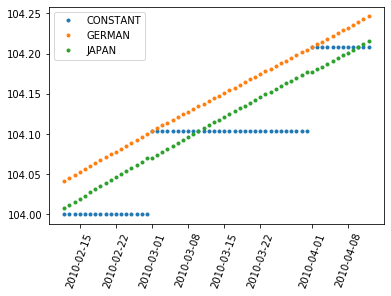

In [39]:
# plot inflation curves
inflation_curve = mkt_testdata.Inflation.CPI(ref_date)
dates = [ref_date + relativedelta(days=d) for d in range(20,80)]

german = [inflation_curve.value(ref_date, date, InflationInterpolation.GERMAN) for date in dates]
japan = [inflation_curve.value(ref_date, date, InflationInterpolation.JAPAN) for date in dates]
const = [inflation_curve.value(ref_date, date, InflationInterpolation.CONSTANT) for date in dates]
plt.plot(dates, const, '.', label = 'CONSTANT')
plt.plot(dates, german, '.', label = 'GERMAN')
plt.plot(dates, japan, '.', label = 'JAPAN')
plt.xticks(rotation=70)
legend = plt.legend()

#DataFrame.from_dict({'date': dates_p, 'index': const, 'japan': japan})

## Pricing

### Pricing Data

As explained in [Overview](../overview.ipynb), we need to setup the respective PricingData object which is *InflationLinkedBondPricingData* for inflation linkers. This object needs the following data
- **spec**: An InflationLinkedBondSpecification object
- **param**: BondPricingParameter that is mainly used to define the model, i.e. JLT or simple discounted cashflow
- **discountCurve**: The discount curve used to discount all cashflows (in case of JLT this is the risk free discount curve, otherwise the risk adjusted discount curve)
- **pricingRequest**: The pricing request defining which figures will be computed, e.g. YTM
- **inflationFwdCurve**: A InflationIndexForwardCurve containing the estimated forward monthly inflation indices
- **inflationFixingReference1**: The fixed inflation value needed to fix the base reference index by interpolation (only needed if base index ref date is before the valuation date)
- **inflationFixingReference2**: The second fixed inflation value for the base index (two values are needed due to interpolation)
- **inflationFixing1**: Fixed inflation index needed to compute inflation adjustment for the next cashflow
- **inflationFixing2**: Fixed inflation index needed to compute inflation adjustment for the next cashflow

In [40]:
pricing_data_infl = pyvacon.pricing.InflationLinkedBondPricingData()
pricing_data_infl.param = pyvacon.pricing.BondPricingParameter()
pricing_data_infl.param.useJLT = False
pricing_data_infl.discountCurve = mkt_testdata.InterestRate.Curves.EONIA(ref_date)
pricing_data_infl.pricingRequest = pyvacon.pricing.PricingRequest()
pricing_data_infl.pricingRequest.setPricingData(False)
pricing_data_infl.pricingRequest.setCleanPrice(True)
pricing_data_infl.pricingRequest.setMacaulayDuration(True)
pricing_data_infl.pricingRequest.setRho(True)
pricing_data_infl.pricingRequest.setConvexity(True)
pricing_data_infl.pricingRequest.setYTM(True)
pricing_data_infl.pricingRequest.setTheta(True)
pricing_data_infl.inflationFwdCurve = inflation_curve
pricing_data_infl.inflationFixingReference1 = 100
pricing_data_infl.inflationFixingReference2 = 100
pricing_data_infl.inflationFixing1 = 10000
pricing_data_infl.inflationFixing2 = 10000
pricing_data_infl.valDate = ref_date

### InflationLinkedBondSpecification

The <code>InflationLinkedBondSpecification</code> is similar to the <code>BondSpecification</code> (for details see [above](#Bond-Pricer-Configuration)). It just adds some inflation related information
- **deflation protection**: This flag determines whether coupons and notional payments are also adjusted in case of deflation
- **inflation interpolation**: This specifies the interpolation method from the methods described [above](#Interpolation-of-price-indices) to derive the inflation index for a certain day in the month. The values that can be used here are defined in <code>pyriva.enums.InflationInterpolation</code>. Currently these are:
    * <code>pyriva.enums.InflationInterpolation.GERMAN</code>
    * <code>pyriva.enums.InflationInterpolation.JAPANESE</code>
    * <code>pyriva.enums.InflationInterpolation.CONSTANT</code>
    * <code>pyriva.enums.InflationInterpolation.UNDEFINED</code>
- **inflation lag**: Needed to compute the month of the respective inflation index used to determine cashflow adjustment (it defines the number of month  before the cashflow month to derive inflation index month used).
- **inflation index**: Defines the inflation index used. This is only needed if automatic setup of pricing data will be used. Otherwise, just the inflation curve defined in the PricingData will be used and this string will be ignored.

**Note**: Moreover, there are the following diffences between the argument lists of <code>BondSpecification</code> and <code>InflationLinkedBondSpecification</code>:
- Order of <code>issue_date</code> and <code>expiry_date</code>
- Coupon Description: <br>
  While inflation linked bond specifications receive the coupon information as <code>coupon_schedule</code>, i.e. as <code>CouponDescription</code> object, plain vanilla bond specifications get the <code>coupon_dates, coupons</code> (for fixed rate coupons) and <code>reference_index, coupon_periods, spreads</code> (for floating rate coupons) explicitly.

In [41]:
object_id = 'Test_Inflation_Bond'
issuer = 'dummy_issuer'
securitization_level = SecuritizationLevel.SENIOR_SECURED
currency = 'EUR'
issue_date = ref_date + relativedelta(days=20)
maturity = 2
expiry_date = issue_date + relativedelta(years=maturity)
notional = 100.0

coupon_schedule = []
period = 12
day_count_convention = DayCounter.ACT365_FIXED
annualized_fixed_coupon = 0.05
for k in range(int(12/period * maturity)):
    accrual_start = ref_date + k*relativedelta(months=period)
    accrual_end = ref_date + (k+1)*relativedelta(months=period)
    payment_date = accrual_end + relativedelta(days=20)
    coupon = pyvacon.instruments.CouponDescription(accrual_start, accrual_end, payment_date, 
                                                   day_count_convention, annualized_fixed_coupon)
    coupon_schedule.append(coupon)

inflationLag = 0
infl_interpol_method = InflationInterpolation.GERMAN
inflation_index = 'dummy_index'
deflationProtection = False
# inflation linked bond specification
inflation_linked_bond = pyvacon.instruments.InflationLinkedBondSpecification(object_id, issuer,
                                                                             securitization_level, currency,
                                                                             issue_date, expiry_date, notional,
                                                                             coupon_schedule, inflationLag,
                                                                             infl_interpol_method,
                                                                             inflation_index, deflationProtection)

### Price Call

In [42]:
pricing_data_infl.spec = inflation_linked_bond
results = pyvacon.pricing.price(pricing_data_infl)
print('{0:20s} Dirty Price: {1:11,.2f},   Macaulay Duration: {2:5.2f}'
      .format(pricing_data_infl.spec.getObjectId(), results.getPrice(), results.getMacaulayDuration()))
print('{0:20s} Clean Price: {1:11,.2f},   Modified Duration: {2:5.2f}'
      .format('', results.getCleanPrice(), - results.getRho('EONIA')/results.getCleanPrice()))
print('{0:20s} Rho * Shift: {1:11,.2f},   Rho: {2:19.2f}'
      .format('', results.getRho('EONIA')*shift, results.getRho('EONIA')))
print('{0:20s} 1/2*Conv.*Shift^2: {1:5,.2f},   Convexity: {2:13,.2f}'.
      format('', results.getConvexity()*shift**2/2, results.getConvexity()))
print('{0:20s} Yield-to-Maturity: {1:7,.4f}, Theta: {2:19,.4f}'.
      format('', results.getYTM(), results.getTheta()))

Test_Inflation_Bond  Dirty Price:      112.23,   Macaulay Duration:  2.01
                     Clean Price:      112.23,   Modified Duration:  2.01
                     Rho * Shift:       -0.02,   Rho:             -225.55
                     1/2*Conv.*Shift^2:  0.00,   Convexity:        458.14
                     Yield-to-Maturity:  0.0015, Theta:             -0.0003
